In [4]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [36]:
from sklearn.preprocessing import LabelEncoder

from scipy.stats import uniform, randint

from sklearn.metrics import auc, plot_confusion_matrix, accuracy_score,roc_auc_score , confusion_matrix, mean_squared_error, classification_report, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [6]:
#read clean csv files
inc_clean_ml = pd.read_csv("inc_clean_ml")
inc_clean = pd.read_csv("inc_clean")
inc = pd.read_csv("inc")

inc_clean_ml.head()

#ML questions -> predict of handle_time + predict closure_code + predict Category (incident, request for change, complaint) + cluster ML + predict prio category form 1-4

,Unnamed: 0,CI_Cat,CI_Subcat,number_cnt,Category,No_of_Reassignments,Closure_Code,No_of_Related_Interactions,Reopened,prio,handle_time_sec,prio_nmbr
0,0,11,57,0.601292,1,26.0,6,1.0,0,2.0,29722740.0,64.0
1,1,1,57,0.415050,1,33.0,10,1.0,1,3.0,6123120.0,27.0
2,2,1,10,0.517551,2,3.0,4,1.0,0,3.0,56601420.0,48.0
3,3,1,57,0.642927,1,13.0,5,1.0,0,2.0,41895720.0,64.0
4,4,1,57,0.345258,1,2.0,6,1.0,0,2.0,26535240.0,64.0


In [22]:
#predict priority with XGBoost

X = inc_clean_ml[["CI_Cat","CI_Subcat", "Category"]]
y = inc_clean_ml["prio"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=39)

In [8]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

c:\Users\timon\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\timon\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:00:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [9]:
y_pred = model.predict(X_test)


c:\Users\timon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


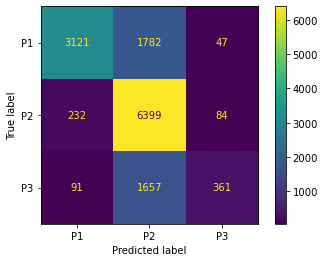

In [10]:
#not tuning model
plot_confusion_matrix(model, X_test, y_test, values_format='d', display_labels=["P1", "P2", "P3"])

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.91      0.63      0.74      4950
         2.0       0.65      0.95      0.77      6715
         3.0       0.73      0.17      0.28      2109

    accuracy                           0.72     13774
   macro avg       0.76      0.58      0.60     13774
weighted avg       0.76      0.72      0.69     13774



In [12]:
#Hyperparameter tuning
#build model with optimized parameters

estimator = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_classes=3,
    nthread=4,
    subsample=0.9,
    colsample_bytree=0.5,
    seed=42, 
    eval_metric='aucpr',
    eval_set=[(X_test, y_test)]
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(50, 350, 50),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_test, y_test)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


c:\Users\timon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\timon\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=Fa

[19:19:21] WARNING: ..\src\learner.cc:576: 
Parameters: { "eval_set", "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False,
                                     eval_metric='aucpr',
                                     eval_set=[(       CI_Cat  CI_Subcat  Category
23104       1         10         1
21948       1         45         1
5234        1         57         1
16759       1         57         1
44143       1         57         1
...       ...        ...       ...
9585        1         45         1
8170       11         57         1
3698        1         45         1
33382       1          3         1
35534       1         10         2

[13774 rows x 3 columns],
                                                23104    2.0
21948    2...
                                     miss

In [13]:
grid_search.best_estimator_


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='aucpr',
              eval_set=[(       CI_Cat  CI_Subcat  Category
23104       1         10         1
21948       1         45         1
5234        1         57         1
16759       1         57         1
44143       1         57         1
...       ...        ...       ...
9585        1         45         1
8170       11         57         1
3698        1         45         1
33382       1          3         1
35534       1         10         2

[13774 rows x 3 columns],
                         23104    2.0
21948    2.0
5234     3.0
16759    2.0
44143    2.0
        ... 
9585...
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='

In [14]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}

c:\Users\timon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


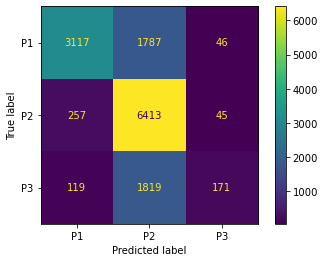

In [15]:
#tuned model
plot_confusion_matrix(grid_search, X_test, y_test, values_format='d', display_labels=["P1", "P2", "P3"])

In [16]:
grid_predictions = grid_search.predict(X_test)

print(classification_report(y_test, grid_predictions))


              precision    recall  f1-score   support

         1.0       0.89      0.63      0.74      4950
         2.0       0.64      0.96      0.77      6715
         3.0       0.65      0.08      0.14      2109

    accuracy                           0.70     13774
   macro avg       0.73      0.56      0.55     13774
weighted avg       0.73      0.70      0.66     13774



In [64]:
#Multiple ML to find a promissing ml algorithm

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

In [65]:
names = ["Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", "XGBoost",
         "Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost",
         "Naive_Bayes", "QDA", "SGD"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="poly", degree=3, C=0.025),
    SVC(kernel="rbf", C=1, gamma=2),
    xgb.XGBClassifier(learning_rate =  0.1, max_depth = 2, n_estimators = 50),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(loss="hinge", penalty="l2")]

In [66]:
scores = []

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    scores.append(score)

c:\Users\timon\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\timon\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:23:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [67]:
scores

[0.6441120952519239,
 0.6622622331929723,
 0.5225787715986642,
 0.7176564541890519,
 0.7122840133585017,
 0.7175838536372876,
 0.7086539857702917,
 0.7183098591549296,
 0.7158414403949469,
 0.706112966458545,
 0.7124292144620299,
 0.6278495716567446,
 0.6530419631189197,
 0.6611006243647451]

In [68]:
df = pd.DataFrame()
df['name'] = names
df['score'] = scores
df

,name,score
0,Nearest_Neighbors,0.644112
1,Linear_SVM,0.662262
2,Polynomial_SVM,0.522579
3,RBF_SVM,0.717656
4,XGBoost,0.712284
5,Gradient_Boosting,0.717584
6,Decision_Tree,0.708654
7,Extra_Trees,0.718310
8,Random_Forest,0.715841
9,Neural_Net,0.706113


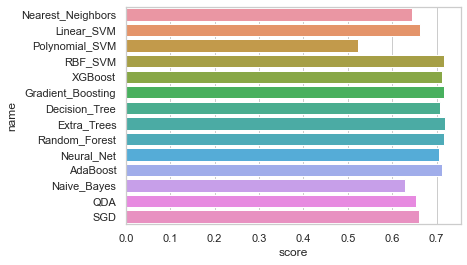

In [69]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=df)

In [ ]:
#Multiple ML on Reopen prediction 